# Figure in the introduction about emitting spot size vs output and colored by imaging time

In [15]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
%matplotlib inline

In [77]:
# range of parameters to calculate for
ni = 100 # number of intervals to sample in emitting spot and source strength

f_min = 0.5 # lower limit of emitting spot to use, mm
f_max = 26 # upper limit of emitting spot to use, mm
di = (f_max-f_min)/ni
f_list = np.arange(f_min, f_max+di, di) # focal spot, mm, over a range of f_min to f_max

e_min = 6 # lower limit of neutron output 1eX n/s
e_max = 12.5 # upper limit of neutron output 1eX n/s
di = (e_max-e_min)/ni
exp_list = np.arange(e_min, e_max+di, 0.05) # use outputs of e_min to e_max in steps of ni
if len(exp_list) > len(f_list): exp_list = np.delete(exp_list, -1)
o_list = np.asarray([10**e for e in exp_list]) # calculates output (neutrons/s) based on given exponent

In [78]:
exp_list

array([ 6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,  6.3 ,  6.35,  6.4 ,
        6.45,  6.5 ,  6.55,  6.6 ,  6.65,  6.7 ,  6.75,  6.8 ,  6.85,
        6.9 ,  6.95,  7.  ,  7.05,  7.1 ,  7.15,  7.2 ,  7.25,  7.3 ,
        7.35,  7.4 ,  7.45,  7.5 ,  7.55,  7.6 ,  7.65,  7.7 ,  7.75,
        7.8 ,  7.85,  7.9 ,  7.95,  8.  ,  8.05,  8.1 ,  8.15,  8.2 ,
        8.25,  8.3 ,  8.35,  8.4 ,  8.45,  8.5 ,  8.55,  8.6 ,  8.65,
        8.7 ,  8.75,  8.8 ,  8.85,  8.9 ,  8.95,  9.  ,  9.05,  9.1 ,
        9.15,  9.2 ,  9.25,  9.3 ,  9.35,  9.4 ,  9.45,  9.5 ,  9.55,
        9.6 ,  9.65,  9.7 ,  9.75,  9.8 ,  9.85,  9.9 ,  9.95, 10.  ,
       10.05, 10.1 , 10.15, 10.2 , 10.25, 10.3 , 10.35, 10.4 , 10.45,
       10.5 , 10.55, 10.6 , 10.65, 10.7 , 10.75, 10.8 , 10.85, 10.9 ,
       10.95, 11.  , 11.05, 11.1 , 11.15, 11.2 , 11.25, 11.3 , 11.35,
       11.4 , 11.45, 11.5 , 11.55, 11.6 , 11.65, 11.7 , 11.75, 11.8 ,
       11.85, 11.9 , 11.95, 12.  , 12.05, 12.1 , 12.15, 12.2 , 12.25,
       12.3 , 12.35,

In [79]:
def numpy_get_optimum_geometry(
    output, # calculates output (neutrons/s) based on given exponent (this is o_list)
    f, # focal spot, mm
    output_bias, # forward bias of output, for DD reaction, approx. vs. isotropic
    d_so_min, # source object minimum distance, mm
    d_od_min, # object detector minimum distance, mm
    d_sd_max, # source detector maximum distance, mm
    d_so_max, # source object maximum distance, mm
    d_sd_ndar, # source detector distance, mm, numpy array
    d_so_ndar, # source object distance, mm, numpy array
    M_ndar, # magnification
    FOV_min, # field of view required to be satisfied
    det_size_max, # maximum detector size
    B_d, # assumed detector resolution, mm
    resolution_goal, # target overall maximum allowed resolution, mm
    detector_efficiency, # assumed detector efficiency
    detector_counts):# required flat field counts per pixel for an image, [-]
    

    B_do_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    B_do_nd = np.true_divide(B_d, M_ndar)

    B_fo_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    B_fo_nd = f * (1-(np.true_divide(1, M_ndar)))
 
    B_o_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    B_o_nd = np.sqrt(B_do_nd**2 + B_fo_nd**2)
    
    imaging_time_effective_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    imaging_time_effective_nd = 4*np.pi*(d_so_ndar**2)*detector_counts/(resolution_goal**2)/output/output_bias/detector_efficiency
#     print(pd.DataFrame(imaging_time_effective_nd))
    
    d_od_ndar = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    d_od_ndar = d_sd_ndar - d_so_ndar
    forbidden_d_od_ndar = d_od_ndar < d_od_min
    
    M_max = det_size_max/FOV_min # maximum allowed magnification
    forbidden_M_ndar = np.zeros((M_ndar.shape[0],M_ndar.shape[1]))
    forbidden_M_ndar = M_ndar > M_max
    
    forbidden_B_o_nd= np.zeros((M_ndar.shape[0],M_ndar.shape[1]))
    forbidden_B_o_nd = B_o_nd > resolution_goal
    
    forbidden_ndar = forbidden_M_ndar | forbidden_B_o_nd | forbidden_d_od_ndar
    
    imaging_time_effective_nd[forbidden_ndar] = 1e10

    best_imaging_time = np.min(imaging_time_effective_nd)
#     print(best_imaging_time)
    loc = np.argwhere(imaging_time_effective_nd==best_imaging_time)

    best_d_so = d_so_ndar[:,0][loc[0][0]]
    best_d_sd = d_sd_ndar[0,loc[0][1]]
#     print(best_d_sd)
#     print(best_d_so)

    return pd.Series([best_imaging_time, best_d_so, best_d_sd], index=['best_imaging_time', 'best_d_so', 'best_d_sd'])


In [80]:
def do_run(run,
        d_so_min, # source object minimum distance, mm
        d_sd_min, # source detector minimum distance, mm
        d_od_min, # object detector minimum distance, mm
        d_sd_max, # source detector maximum distance, mm
        d_so_max, # source object maximum distance, mm
        FOV_min, # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max, # maximum detector size, mm lenght of the detector
        B_d, # assumed detector resolution, mm
        resolution_goal, # target overall maximum allowed resolution, mm
        detector_efficiency, # assumed detector efficiency, [-]
        detector_counts, # required flat field counts per pixel for an image, [-]
        output_bias): # forward bias of output, for DD reaction, approx. vs. isotropic):
    data = pd.DataFrame()


    ni = 5 # number of options in each d_sd and d_so
    d_so_ar = np.arange(d_so_min,d_so_max+ni, ni) # Roberts data
    # d_so_ar = np.linspace(d_so_min,d_so_max, ni) # Roberts data

    ni = 5 # number of options in each d_sd and d_so
    d_sd_ar = np.arange(d_so_min,d_sd_max+ni, ni) # Roberts data
    # d_sd_ar = np.linspace(d_sd_min,d_sd_max, ni) # Roberts data

    d_so_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    d_sd_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))

    d_so_ndar = np.tile(d_so_ar, (d_sd_ar.shape[0],1)).T
    d_sd_ndar = np.tile(d_sd_ar, (d_so_ar.shape[0],1))

    # magnification
    M_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    M_ndar = d_sd_ndar/d_so_ndar
    kk = 0
    start_time = time.time()
    for ii in range(0,len(f_list)):
        # test for the first ten entries
        for jj in range(0,len(o_list)):
            if kk % 1000 == 0: 
                print(f'Done {kk}')
            kk = kk + 1
            f = f_list[ii]
            output = o_list[jj]
            exp = exp_list[jj]
            s = numpy_get_optimum_geometry(
                output, # calculates output (neutrons/s) based on given exponent (this is o_list)
                f, # focal spot, mm
                output_bias, # forward bias of output, for DD reaction, approx. vs. isotropic
                d_so_min, # source object minimum distance, mm
                d_od_min, # object detector minimum distance, mm
                d_sd_max, # source detector maximum distance, mm
                d_so_max, # source object maximum distance, mm
                d_sd_ndar, # source detector distance, mm, numpy array
                d_so_ndar, # source object distance, mm, numpy array
                M_ndar, # magnification
                FOV_min, # field of view required to be satisfied
                det_size_max, # maximum detector size
                B_d, # assumed detector resolution, mm
                resolution_goal, # target overall maximum allowed resolution, mm
                detector_efficiency, # assumed detector efficiency
                detector_counts)# required flat field counts per pixel for an image, [-]


            s['f'] = f
            s['exp'] = exp
            s['output'] = output
            this_data = pd.DataFrame(s)
            data = data.append(this_data.T) 

    duration = (time.time() - start_time)
    print("--- %s seconds ---" % duration)

    data_plot = pd.pivot_table(data, values='best_imaging_time', index='f', columns='exp')
    data_plot[data_plot < 0.05] = np.nan # cutoff very fast imaging times
    data_plot = data_plot / 60 # convert to hours
    data_plot[data_plot > 100] = np.nan # cutoff 100 minutes
    do_plot(data_plot, run)

In [81]:
def do_plot(data_plot, run):
    from matplotlib.colors import LogNorm
    import math 
    import os
    import matplotlib
    import matplotlib.ticker as ticker
    os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
    plt.rc('text', usetex=True)
    plt.rc('font', weight='bold')
    matplotlib.rcParams["font.weight"] = "bold"
    matplotlib.rcParams["axes.labelweight"] = "bold"
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Arial'
    matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
    matplotlib.rcParams['mathtext.tt'] = 'Arial'
    matplotlib.rcParams['mathtext.cal'] = 'Arial'
    matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
    outfile = '/Users/hkromer/02_PhD/02_Data/10.OutputVSEmittingSpot_Robert/my_plots/'

    outfile = f"{outfile}{run}.pdf"
    fig = plt.figure(figsize=(8, 6))
    num_ticks = 10
    fs = 20
    # ylabels
    # the index of the position of yticks
    ylabels = data_plot.index.values
    yticks = np.linspace(0, len(ylabels) - 1, num_ticks, dtype=np.int)
    # the content of labels of these yticks
    yticklabels = [np.round(ylabels[idx], 0) for idx in yticks]

    # xlabels
    # # the index of the position of xticks
    xlabels = data_plot.columns.values
    xlabels = np.round(xlabels, 2)
    # xticks = np.linspace(0, len(xlabels) - 1, num_ticks, dtype=np.int)
    # # the content of labels of these yticks
    # xticklabels = [np.round(xlabels[idx], 1) for idx in xticks]
    # print(xticks, xticklabels)
    xticklabels = np.arange(xlabels[0],xlabels[-1]+0.5, 0.5)
    xticks = np.asarray([])
    for ii in range(0,len(xticklabels)):
        for jj in range(0,len(xlabels)):
            if xticklabels[ii] == xlabels[jj]:
                xticks = np.append(xticks, jj)
    xticks = xticks.astype(int)
    assert xticklabels.all() == xlabels[xticks].all()

    log_norm = LogNorm(vmin=data_plot.min().min(), vmax=data_plot.max().max())
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data_plot.min().min())), 1+math.ceil(math.log10(data_plot.max().max())))]

    # cbar_ticks = [0,1,10,1e2,1e3,1e4,1e5]
    # sns.set(font_scale = 2)
    sns.set_context("paper")
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white',"xtick.bottom" : True, "ytick.left" : True, 'font.weight': "bold"})

#     ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='coolwarm', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
    ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='rainbow', norm=log_norm, cbar_kws={"ticks": cbar_ticks})

    # ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_yticks(yticks)
    ax.set_xticks(xticks)
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fs-2) 
    for label in ax.get_yticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    for label in ax.get_xticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    # ax.tick_params('x', colors='black', labelsize=fs-2)
    # ax.tick_params('y', colors='black', labelsize=fs-2)
    plt.xlabel(r'\textbf{x, where neutron output} $10^x$ \textbf{neutrons/s}', fontsize=fs)
    cbar.ax.set_ylabel(r'\textbf{Time per radiograph [min]}', rotation=90)
    plt.ylabel(r'\textbf{Emitting spot size [mm]}', fontsize=fs)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

In [82]:
# model assumptions
run = 1
d_so_min = 100 # source object minimum distance, mm
d_sd_min = 100 # source detector minimum distance, mm
d_od_min = 100 # object detector minimum distance, mm
d_sd_max = 10000 # source detector maximum distance, mm
d_so_max = 10000 # source object maximum distance, mm
FOV_min = 200 # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
det_size_max = 1000 # maximum detector size, mm lenght of the detector
B_d = 0.8 # assumed detector resolution, mm
resolution_goal = 1.2 # target overall maximum allowed resolution, mm
detector_efficiency = 0.05 # assumed detector efficiency, [-]
detector_counts = 3000 # required flat field counts per pixel for an image, [-]
output_bias = 1.4 # forward bias of output, for DD reaction, approx. vs. isotropic

In [83]:
d_so_mins = pd.Series([50, 100, 200], name='d_so_min')
d_sd_mins = pd.Series([50, 100, 200], name='d_sd_min')
d_od_mins = pd.Series([50, 100, 200], name='d_od_min')
d_sd_maxs = pd.Series([500, 10000, 20000], name='d_sd_max')
d_so_maxs = pd.Series([500, 10000, 20000], name='d_so_max')
FOV_mins = pd.Series([100, 200, 400], name='FOV_min')
det_size_maxs = pd.Series([500, 1000, 2000], name='det_size_max')
B_ds = pd.Series([0.4, 0.8, 1.6], name='B_d')
resolution_goals = pd.Series([0.6, 1.2, 2.4], name='resolution_goal')
detector_efficiencys = pd.Series([0.025, 0.05, 0.1], name='detector_efficiency')
detector_countss = pd.Series([1500, 3000, 6000], name='detector_counts')
series = [d_so_mins, d_sd_mins, d_od_mins, d_sd_maxs, d_so_maxs, FOV_mins, det_size_maxs, B_ds,resolution_goals, detector_efficiencys, detector_countss ]
df = pd.concat(series, axis=1)
for val in df.loc[:,'det_size_max']:
    print(val)
# df

500
1000
2000


In [84]:
df_runs = pd.DataFrame(columns=df.columns)

# col = 'd_sd_min'
# cols = df.columns.tolist()
# cols.remove(col)
# s = df.loc[1,cols]
# s[col] = np.nan
# df2 = pd.DataFrame([s])
# df_runs = df_runs.append(df2)

# col = 'resolution_goal'
# cols = df.columns.tolist()
# cols.remove(col)
# s = df.loc[1,cols]
# s[col] = np.nan
# df2 = pd.DataFrame([s])
# df_runs = df_runs.append(df2)

for col in df.columns:
    for val in df.loc[:,col]:
        cols = df.columns.tolist()
        cols.remove(col)
        s = df.loc[1,cols]
        s[col] = val
        df2 = pd.DataFrame([s])
        df_runs = df_runs.append(df2)

df_runs=df_runs.reset_index(drop=True)
dupl_index = df_runs[df_runs.duplicated()].index.values # show duplicates
# print(dupl_index)
# print(len(df_runs))
df_runs = df_runs.drop_duplicates(keep='first')
df_runs = df_runs.reset_index(drop=True)
# print(len(df_runs))
df_runs['run'] = df_runs.index+1
df_runs

,d_so_min,d_sd_min,d_od_min,d_sd_max,d_so_max,FOV_min,det_size_max,B_d,resolution_goal,detector_efficiency,detector_counts,run
0,50.0,100.0,100.0,10000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,1
1,100.0,100.0,100.0,10000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,2
2,200.0,100.0,100.0,10000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,3
3,100.0,50.0,100.0,10000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,4
4,100.0,200.0,100.0,10000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,5
5,100.0,100.0,50.0,10000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,6
6,100.0,100.0,200.0,10000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,7
7,100.0,100.0,100.0,500.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,8
8,100.0,100.0,100.0,20000.0,10000.0,200.0,1000.0,0.8,1.2,0.050,3000.0,9
9,100.0,100.0,100.0,10000.0,500.0,200.0,1000.0,0.8,1.2,0.050,3000.0,10


# Do the simulation and plot for one set of parameters
## For the plot in the introduction

In [85]:
def do_plot_thesis(data_plot, run, outfile):
    from matplotlib.colors import LogNorm
    import math 
    import os
    import matplotlib
    import matplotlib.ticker as ticker
    os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
    plt.rc('text', usetex=True)
    plt.rc('font', weight='bold')
    matplotlib.rcParams["font.weight"] = "bold"
    matplotlib.rcParams["axes.labelweight"] = "bold"
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Arial'
    matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
    matplotlib.rcParams['mathtext.tt'] = 'Arial'
    matplotlib.rcParams['mathtext.cal'] = 'Arial'
    matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
#     outfile = '/Users/hkromer/02_PhD/02_Data/10.OutputVSEmittingSpot_Robert/my_plots/'

#     outfile = f"{outfile}{run}.pdf"
    fig = plt.figure(figsize=(8, 6))
    num_ticks = 10
    fs = 20
    # ylabels
    # the index of the position of yticks
    ylabels = data_plot.index.values
    yticks = np.linspace(0, len(ylabels) - 1, num_ticks, dtype=np.int)
    # the content of labels of these yticks
    yticklabels = [np.round(ylabels[idx], 0) for idx in yticks]

    # xlabels
    # # the index of the position of xticks
    xlabels = data_plot.columns.values
    xlabels = np.round(xlabels, 2)
    # xticks = np.linspace(0, len(xlabels) - 1, num_ticks, dtype=np.int)
    # # the content of labels of these yticks
    # xticklabels = [np.round(xlabels[idx], 1) for idx in xticks]
    # print(xticks, xticklabels)
    xticklabels = np.arange(xlabels[0],xlabels[-1]+0.5, 0.5)
    xticks = np.asarray([])
    for ii in range(0,len(xticklabels)):
        for jj in range(0,len(xlabels)):
            if xticklabels[ii] == xlabels[jj]:
                xticks = np.append(xticks, jj)
    xticks = xticks.astype(int)
    assert xticklabels.all() == xlabels[xticks].all()

    log_norm = LogNorm(vmin=data_plot.min().min(), vmax=data_plot.max().max())
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data_plot.min().min())), 1+math.ceil(math.log10(data_plot.max().max())))]

    # cbar_ticks = [0,1,10,1e2,1e3,1e4,1e5]
    # sns.set(font_scale = 2)
    sns.set_context("paper")
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white',"xtick.bottom" : True, "ytick.left" : True, 'font.weight': "bold"})

#     ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='coolwarm', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
    ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='rainbow', norm=log_norm, cbar_kws={"ticks": cbar_ticks})

    # ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_yticks(yticks)
    ax.set_xticks(xticks)
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fs-2) 
    for label in ax.get_yticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    for label in ax.get_xticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    # ax.tick_params('x', colors='black', labelsize=fs-2)
    # ax.tick_params('y', colors='black', labelsize=fs-2)
    plt.xlabel(r'\textbf{x, where neutron output} $10^x$ \textbf{neutrons/s}', fontsize=fs)
    cbar.ax.set_ylabel(r'\textbf{Time per radiograph [min]}', rotation=90)
    plt.ylabel(r'\textbf{Emitting spot size [mm]}', fontsize=fs)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

In [86]:
def do_run_thesis(outfile, run,
        d_so_min, # source object minimum distance, mm
        d_sd_min, # source detector minimum distance, mm
        d_od_min, # object detector minimum distance, mm
        d_sd_max, # source detector maximum distance, mm
        d_so_max, # source object maximum distance, mm
        FOV_min, # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max, # maximum detector size, mm lenght of the detector
        B_d, # assumed detector resolution, mm
        resolution_goal, # target overall maximum allowed resolution, mm
        detector_efficiency, # assumed detector efficiency, [-]
        detector_counts, # required flat field counts per pixel for an image, [-]
        output_bias): # forward bias of output, for DD reaction, approx. vs. isotropic):
    data = pd.DataFrame()


    ni = 5 # number of options in each d_sd and d_so
    d_so_ar = np.arange(d_so_min,d_so_max+ni, ni) # Roberts data
    # d_so_ar = np.linspace(d_so_min,d_so_max, ni) # Roberts data

    ni = 5 # number of options in each d_sd and d_so
    d_sd_ar = np.arange(d_so_min,d_sd_max+ni, ni) # Roberts data
    # d_sd_ar = np.linspace(d_sd_min,d_sd_max, ni) # Roberts data

    d_so_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    d_sd_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))

    d_so_ndar = np.tile(d_so_ar, (d_sd_ar.shape[0],1)).T
    d_sd_ndar = np.tile(d_sd_ar, (d_so_ar.shape[0],1))

    # magnification
    M_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    M_ndar = d_sd_ndar/d_so_ndar
    kk = 0
    start_time = time.time()
    for ii in range(0,len(f_list)):
        # test for the first ten entries
        for jj in range(0,len(o_list)):
            if kk % 1000 == 0: 
                print(f'Done {kk}')
            kk = kk + 1
            f = f_list[ii]
            output = o_list[jj]
            exp = exp_list[jj]
            s = numpy_get_optimum_geometry(
                output, # calculates output (neutrons/s) based on given exponent (this is o_list)
                f, # focal spot, mm
                output_bias, # forward bias of output, for DD reaction, approx. vs. isotropic
                d_so_min, # source object minimum distance, mm
                d_od_min, # object detector minimum distance, mm
                d_sd_max, # source detector maximum distance, mm
                d_so_max, # source object maximum distance, mm
                d_sd_ndar, # source detector distance, mm, numpy array
                d_so_ndar, # source object distance, mm, numpy array
                M_ndar, # magnification
                FOV_min, # field of view required to be satisfied
                det_size_max, # maximum detector size
                B_d, # assumed detector resolution, mm
                resolution_goal, # target overall maximum allowed resolution, mm
                detector_efficiency, # assumed detector efficiency
                detector_counts)# required flat field counts per pixel for an image, [-]


            s['f'] = f
            s['exp'] = exp
            s['output'] = output
            this_data = pd.DataFrame(s)
            data = data.append(this_data.T) 

    duration = (time.time() - start_time)
    print("--- %s seconds ---" % duration)

    data_plot = pd.pivot_table(data, values='best_imaging_time', index='f', columns='exp')
    data_plot[data_plot < 0.05] = np.nan # cutoff very fast imaging times
    data_plot = data_plot / 60 # convert to hours
    data_plot.to_csv('/Users/hkromer/02_PhD/tmp/data_plot_nocutoff.csv')
    data_plot[data_plot > 300] = np.nan # cutoff 100 minutes
    data_plot.to_csv('/Users/hkromer/02_PhD/tmp/data_plot.csv')
    do_plot_thesis(data_plot, run, outfile)


In [87]:
row = df_runs.iloc[2,:]
row

d_so_min                 200.00
d_sd_min                 100.00
d_od_min                 100.00
d_sd_max               10000.00
d_so_max               10000.00
FOV_min                  200.00
det_size_max            1000.00
B_d                        0.80
resolution_goal            1.20
detector_efficiency        0.05
detector_counts         3000.00
run                        3.00
Name: 2, dtype: float64

Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
--- 2184.328854084015 seconds ---


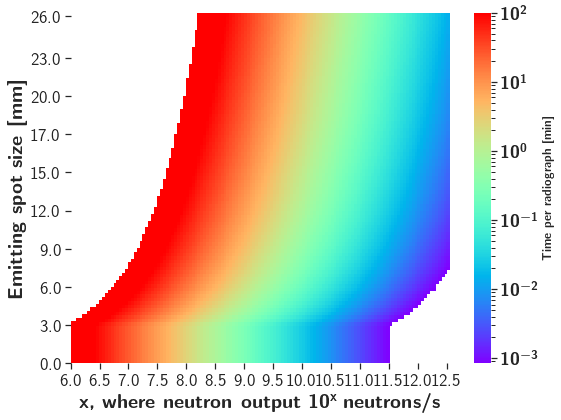

In [88]:
outfile = '/Users/hkromer/polybox/Thesis/Chapters/Introduction/Figures/emitting_spot_output_imaging_time/emitting_spot_output_imaging_time_2.pdf'

do_run_thesis(outfile,run=row['run'],
        d_so_min=row['d_so_min'], # source object minimum distance, mm
        d_sd_min=row['d_sd_min'], # source detector minimum distance, mm
        d_od_min=row['d_od_min'], # object detector minimum distance, mm
        d_sd_max=row['d_sd_max'], # source detector maximum distance, mm
        d_so_max=row['d_so_max'], # source object maximum distance, mm
        FOV_min=row['FOV_min'], # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max=row['det_size_max'], # maximum detector size, mm lenght of the detector
        B_d=row['B_d'], # assumed detector resolution, mm
        resolution_goal=row['resolution_goal'], # target overall maximum allowed resolution, mm
        detector_efficiency=row['detector_efficiency'], # assumed detector efficiency, [-]
        detector_counts=row['detector_counts'], # required flat field counts per pixel for an image, [-]
        output_bias=output_bias)

In [89]:
data_plot.columns.values

array([ 6.06,  6.13,  6.2 ,  6.27,  6.34,  6.41,  6.48,  6.55,  6.62,
        6.69,  6.76,  6.83,  6.9 ,  6.97,  7.04,  7.11,  7.18,  7.25,
        7.32,  7.39,  7.46,  7.53,  7.6 ,  7.67,  7.74,  7.81,  7.88,
        7.95,  8.02,  8.09,  8.16,  8.23,  8.3 ,  8.37,  8.44,  8.51,
        8.58,  8.65,  8.72,  8.79,  8.86,  8.93,  9.  ,  9.07,  9.14,
        9.21,  9.28,  9.35,  9.42,  9.49,  9.56,  9.63,  9.7 ,  9.77,
        9.84,  9.91,  9.98, 10.05, 10.12, 10.19, 10.26, 10.33, 10.4 ,
       10.47, 10.54, 10.61, 10.68, 10.75, 10.82, 10.89, 10.96, 11.03,
       11.1 , 11.17, 11.24, 11.31, 11.38, 11.45, 11.52, 11.59, 11.66,
       11.73, 11.8 , 11.87, 11.94, 12.01, 12.08, 12.15, 12.22, 12.29,
       12.36, 12.43, 12.5 ])

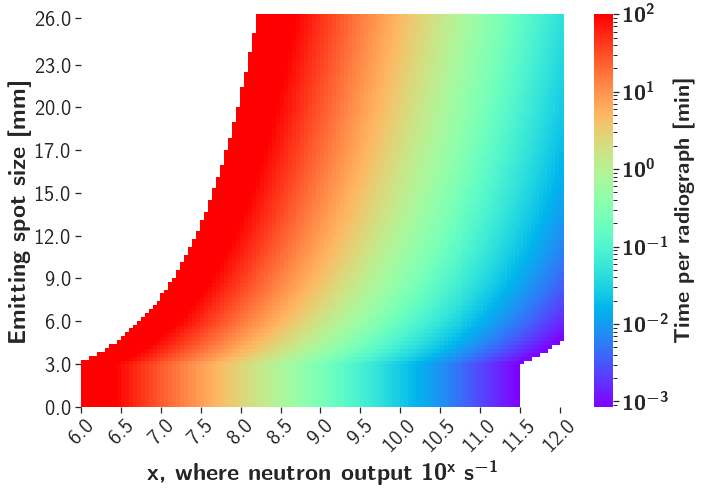

In [108]:
from matplotlib.colors import LogNorm
import math 
import os
import pandas as np
import numpy as np
from matplotlib.colors import LogNorm
import math 
import os
import matplotlib
import matplotlib.ticker as ticker
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams["font.weight"] = "bold"
matplotlib.rcParams["axes.labelweight"] = "bold"
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
#     outfile = '/Users/hkromer/02_PhD/02_Data/10.OutputVSEmittingSpot_Robert/my_plots/'
data_plot = pd.read_csv('/Users/hkromer/02_PhD/tmp/data_plot.csv', index_col=0)
data_plot.columns = data_plot.columns.astype(float)
data_plot = data_plot.loc[:, data_plot.columns <= 12]
#     outfile = f"{outfile}{run}.pdf"
fig = plt.figure(figsize=(10, 7))
num_ticks = 10
fs = 24
# ylabels
# the index of the position of yticks
ylabels = data_plot.index.values
yticks = np.linspace(0, len(ylabels) - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
yticklabels = [np.round(ylabels[idx], 0) for idx in yticks]

# xlabels
# # the index of the position of xticks
xlabels = data_plot.columns.values
xlabels = np.round(xlabels, 2)
# xticks = np.linspace(0, len(xlabels) - 1, num_ticks, dtype=np.int)
# # the content of labels of these yticks
# xticklabels = [np.round(xlabels[idx], 1) for idx in xticks]
# print(xticks, xticklabels)
xticklabels = np.arange(xlabels[0],xlabels[-1]+0.5, 0.5)
xticks = np.asarray([])
for ii in range(0,len(xticklabels)):
    for jj in range(0,len(xlabels)):
        if xticklabels[ii] == xlabels[jj]:
            xticks = np.append(xticks, jj)
xticks = xticks.astype(int)
assert xticklabels.all() == xlabels[xticks].all()

log_norm = LogNorm(vmin=data_plot.min().min(), vmax=data_plot.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data_plot.min().min())), 1+math.ceil(math.log10(data_plot.max().max())))]

# cbar_ticks = [0,1,10,1e2,1e3,1e4,1e5]
# sns.set(font_scale = 2)
sns.set_context("paper")
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white',"xtick.bottom" : True, "ytick.left" : True, 'font.weight': "bold"})

#     ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='coolwarm', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='rainbow', norm=log_norm, cbar_kws={"ticks": cbar_ticks})

# ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fs-2) 
for label in ax.get_yticklabels():
    label.set_size(fs-2)
    label.set_weight("heavy")
#     label.set_color("black")
for label in ax.get_xticklabels():
    label.set_size(fs-2)
    label.set_weight("heavy")
#     label.set_color("black")
# ax.tick_params('x', colors='black', labelsize=fs-2)
# ax.tick_params('y', colors='black', labelsize=fs-2)

plt.xlabel(r'\textbf{x, where neutron output} $10^x$ \textbf{s$^{-1}$}', fontsize=fs)
cbar.ax.set_ylabel(r'\textbf{Time per radiograph [min]}', fontsize=fs-2, rotation=90)
plt.ylabel(r'\textbf{Emitting spot size [mm]}', fontsize=fs)
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
plt.tight_layout()
outfile = '/Users/hkromer/polybox/Thesis/Chapters/Introduction/Figures/emitting_spot_output_imaging_time/emitting_spot_output_imaging_time_2.pdf'

plt.savefig(outfile)
plt.show()

In [95]:
data_plot = pd.read_csv('/Users/hkromer/02_PhD/tmp/data_plot.csv', index_col=0)
data_plot.columns = data_plot.columns.astype(float)

In [92]:
set(labels)

{Text(0.5, 0, '6.0'),
 Text(10.5, 0, '6.5'),
 Text(100.5, 0, '11.0'),
 Text(105.5, 0, '11.25'),
 Text(110.5, 0, '11.5'),
 Text(115.5, 0, '11.75'),
 Text(120.5, 0, '12.0'),
 Text(125.5, 0, '12.25'),
 Text(130.5, 0, '12.5'),
 Text(15.5, 0, '6.75'),
 Text(20.5, 0, '7.0'),
 Text(25.5, 0, '7.25'),
 Text(30.5, 0, '7.5'),
 Text(35.5, 0, '7.75'),
 Text(40.5, 0, '8.0'),
 Text(45.5, 0, '8.25'),
 Text(5.5, 0, '6.25'),
 Text(50.5, 0, '8.5'),
 Text(55.5, 0, '8.75'),
 Text(60.5, 0, '9.0'),
 Text(65.5, 0, '9.25'),
 Text(70.5, 0, '9.5'),
 Text(75.5, 0, '9.75'),
 Text(80.5, 0, '10.0'),
 Text(85.5, 0, '10.25'),
 Text(90.5, 0, '10.5'),
 Text(95.5, 0, '10.75')}

In [63]:
data_plot

,6.06,6.13,6.20,6.27,6.34,6.41,6.48,6.55,6.62,6.69,...,11.87,11.94,12.01,12.08,12.15,12.22,12.29,12.36,12.43,12.50
f,,,,,,,,,,,,,,,,,,,,,
0.500,217.159747,184.832921,157.31833,133.899615,113.967055,97.001696,82.561833,70.271517,59.810761,50.907214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.755,217.159747,184.832921,157.31833,133.899615,113.967055,97.001696,82.561833,70.271517,59.810761,50.907214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.010,217.159747,184.832921,157.31833,133.899615,113.967055,97.001696,82.561833,70.271517,59.810761,50.907214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.265,217.159747,184.832921,157.31833,133.899615,113.967055,97.001696,82.561833,70.271517,59.810761,50.907214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.520,217.159747,184.832921,157.31833,133.899615,113.967055,97.001696,82.561833,70.271517,59.810761,50.907214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.057719,0.049127,0.041814,0.035590,0.030292,0.025782,0.021944,0.018678,0.015897,0.013531
25.235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.058826,0.050069,0.042616,0.036272,0.030872,0.026277,0.022365,0.019036,0.016202,0.013790
25.490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.060168,0.051211,0.043588,0.037099,0.031577,0.026876,0.022875,0.019470,0.016572,0.014105


In [ ]:
def each_row(row):
    do_run(run=row['run'],
        d_so_min=row['d_so_min'], # source object minimum distance, mm
        d_sd_min=row['d_sd_min'], # source detector minimum distance, mm
        d_od_min=row['d_od_min'], # object detector minimum distance, mm
        d_sd_max=row['d_sd_max'], # source detector maximum distance, mm
        d_so_max=row['d_so_max'], # source object maximum distance, mm
        FOV_min=row['FOV_min'], # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max=row['det_size_max'], # maximum detector size, mm lenght of the detector
        B_d=row['B_d'], # assumed detector resolution, mm
        resolution_goal=row['resolution_goal'], # target overall maximum allowed resolution, mm
        detector_efficiency=row['detector_efficiency'], # assumed detector efficiency, [-]
        detector_counts=row['detector_counts'], # required flat field counts per pixel for an image, [-]
        output_bias=output_bias)
    print(f'Doing run {row.run}')
    
df_runs.apply(lambda x: each_row(x), axis=1)

In [119]:
# calibration of figure

# x axis
# reference is 6.0
# 0.5 unit in x is 39.932 pt
# 1 unit is 
d_x = 39.932/0.5
x_0 = 87.012 # pt, at x=6.0


# y axis
# reference is 0
# 3 mm is 42.765 pt
# 1 mm is
d_y = 42.765/3
y_0 = 412.904

In [121]:
# Gen. I: non rotating target 
# 2 mm spot size
d = 2 # mm
output = 6.6e6 # 1/s

X = np.log10(output)-6
print(f"X position of point is: {x_0+d_x*X}")
Y = y_0 - d*d_y
print(f"Y position of point is: {Y}")


X position of point is: 152.4640568681158
Y position of point is: 384.394


In [122]:
# Gen. I: rotating target 
# 2 mm spot size
d = 2.5 # mm
output = 2.9e7 # 1/s

X = np.log10(output)-6
print(f"X position of point is: {x_0+d_x*X}")
Y = y_0 - d*d_y
print(f"Y position of point is: {Y}")

X position of point is: 203.80495370420226
Y position of point is: 377.2665


In [123]:
# Gen. II: rotating target 
# 2 mm spot size
d = 2.5 # mm
output = 5e7 # 1/s

X = np.log10(output)-6
print(f"X position of point is: {x_0+d_x*X}")
Y = y_0 - d*d_y
print(f"Y position of point is: {Y}")

X position of point is: 222.6985404262918
Y position of point is: 377.2665
